### With PYMC
The BN is functional Bayesian network, which have the ability to generate continuous probability distribution for QoI (quantity of interest). However, for multiple buildings, the process is computationally heavu, therefore, we use discrete Bayesian network instead. The uncertainty quantification is less accurate, just an approximate. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pgmpy.base import DAG
from pgmpy.models import FunctionalBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.factors.hybrid import FunctionalCPD
import pyro.distributions as dist
# from pgmpy.utils import get_example_model
from IPython.display import Image
from sklearn.metrics import mutual_info_score

import pymc as pm
import arviz as az

import time

from graphviz import Digraph
from IPython.display import Image

from scipy.stats import spearmanr

INFO:arviz:Found 'auto' as default backend, checking available backends
INFO:arviz:Matplotlib is available, defining as default backend
INFO:arviz.preview:arviz_base available, exposing its functions as part of arviz.preview
INFO:arviz.preview:arviz_stats available, exposing its functions as part of arviz.preview
INFO:arviz.preview:arviz_plots available, exposing its functions as part of arviz.preview


## The BN

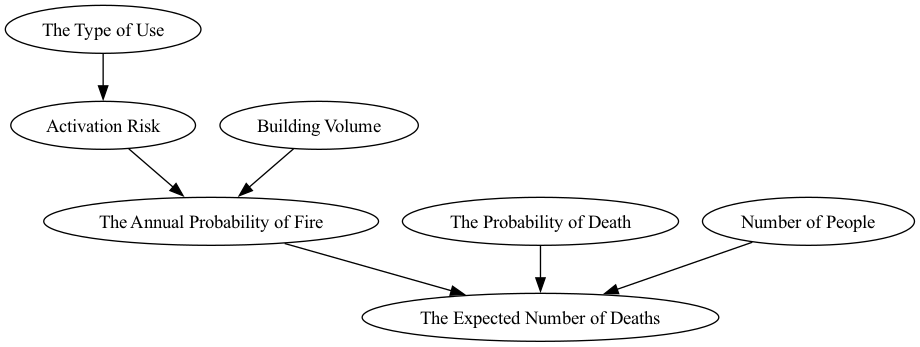

In [2]:
BN_risk = DAG()
BN_risk.add_nodes_from(nodes=['The Type of Use'])
BN_risk.add_edges_from(ebunch=[('The Type of Use', 'Activation Risk')])
BN_risk.add_edges_from(ebunch=[('Building Volume', 'The Annual Probability of Fire'),
                               ('Activation Risk', 'The Annual Probability of Fire')])
BN_risk.add_edges_from(ebunch=[('The Annual Probability of Fire', 'The Expected Number of Deaths'),
                               ('The Probability of Death', 'The Expected Number of Deaths'),
                               ('Number of People', 'The Expected Number of Deaths')])

# The expected numebr of deaths is just an risk indicator
viz = BN_risk.to_graphviz()
viz.draw('model.png', prog='dot')
Image('model.png')

# Aleatory uncertainty: irreducible uncertainty due to inherent randomness
# Activation risk, Building volume
# maybe the probability of death
# Epistemic uncertainty: reducible uncertainty due to lack of knowledge
# The probability of death - lack of knowledge, but what if it is beta distributed?
# Number of people - lack of knowledge, if known the distribution with more modern analysis
# Question: should I consider uncertainty in the causal nodes in the system? such as add a random noise on the annual probability of fire


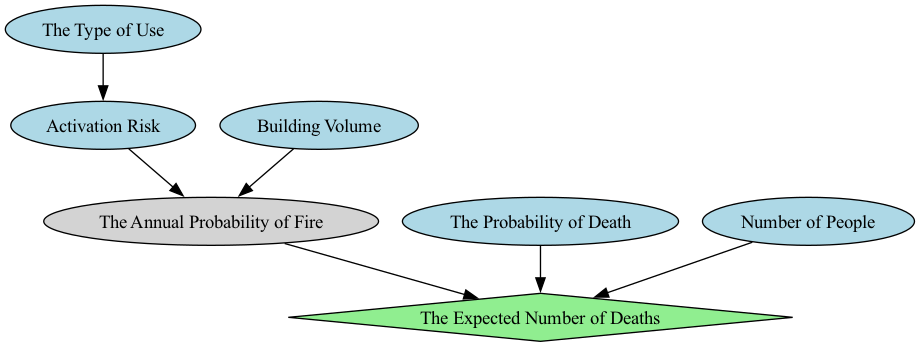

In [3]:
from graphviz import Digraph
from IPython.display import Image

# Define DAG
BN_risk = Digraph(format='png')
BN_risk.attr(rankdir='TB')  # top-to-bottom layout

# Add nodes
input_nodes = ['The Type of Use', 'Activation Risk', 'Building Volume',
               'The Probability of Death', 'Number of People']
intermediate_nodes = ['The Annual Probability of Fire']
output_nodes = ['The Expected Number of Deaths']

# Input nodes: blue ellipses
for node in input_nodes:
    BN_risk.node(node, style='filled', fillcolor='lightblue', shape='ellipse')

# Intermediate node: gray ellipse
for node in intermediate_nodes:
    BN_risk.node(node, style='filled', fillcolor='lightgray', shape='ellipse')

# Output node: green diamond
for node in output_nodes:
    BN_risk.node(node, style='filled', fillcolor='lightgreen', shape='diamond')

# Add edges
BN_risk.edges([('The Type of Use', 'Activation Risk')])
BN_risk.edges([
    ('Building Volume', 'The Annual Probability of Fire'),
    ('Activation Risk', 'The Annual Probability of Fire')
])
BN_risk.edges([
    ('The Annual Probability of Fire', 'The Expected Number of Deaths'),
    ('The Probability of Death', 'The Expected Number of Deaths'),
    ('Number of People', 'The Expected Number of Deaths')
])

# Render and display
BN_risk.render('model', view=True)
Image('model.png')


In [6]:
### Add Functional CPD
BN_fun = FunctionalBayesianNetwork(BN_risk.edges())

### Function for the death risk CPD
death_number_cpd = FunctionalCPD(
    variable='The Expected Number of Deaths',
    fn=lambda parents: parents['The Probability of Death'] *
                       parents['Number of People'] *
                       parents['The Annual Probability of Fire'],
    parents=['The Probability of Death', 'Number of People', 'The Annual Probability of Fire']
)
BN_fun.add_cpds(death_number_cpd)

### Another way to define the same CPD
def compute_death_number_cpd(parents):
    return (parents['The Probability of Death'] *
            parents['Number of People'] *
            parents['The Annual Probability of Fire'])

death_number_cpd = FunctionalCPD(
    variable='The Expected Number of Deaths',
    fn=compute_death_number_cpd,
    parents=['The Probability of Death', 'Number of People', 'The Annual Probability of Fire']
)

INFO:pgmpy:Functional BN requires pytorch backend. Switching.


In [7]:
### Function for the fire probability CPD
# Define Zweckcode categories (purpose codes for buildings)
activation_risk = [
    "Low Risk",
    "Middle Risk",
    "High Risk"
]

# Define risk factors dictionary
risk_factors = {
    "Low Risk": {
        "alpha": -9.011,
        "beta": 0.434,
        "gamma": 0.018
    },
    "Middle Risk": {
        "alpha": -9.005,
        "beta": 0.536,
        "gamma": 0.034
    },
    "High Risk": {
        "alpha": -9.422,
        "beta": 0.669,
        "gamma": 0.030
    }
}

def compute_prob_fire_cpd(parents):
    buidling_volume = parents['Building Volume']
    ar_level = parents['Activation Risk']

    alpha = risk_factors[ar_level]['alpha']
    beta = risk_factors[ar_level]['beta']
    gamma = risk_factors[ar_level]['gamma']

    prob_fire = 2/np.pi * np.arctan(1.0 * np.exp(alpha) * buidling_volume ** beta / np.exp(21 * gamma))
    # a is useful if restrict x in arctan(x) to [0,a], then a is teh scaling factor
    return prob_fire

fire_prob_cpd = FunctionalCPD(
    variable='The Annual Probability of Fire',
    fn=compute_prob_fire_cpd,
    parents=['Building Volume', 'Activation Risk']
)

BN_fun.add_cpds(fire_prob_cpd)

## The Fire risk model, generate synthetic data for experiment

In [ ]:
#----------------------------
# Functions to calculate proabilities and risks
# Dictionaries for risk factors
#----------------------------


# Define Zweckcode categories (purpose codes for buildings)
activation_risk = [
    "Low Risk",
    "Middle Risk",
    "High Risk"
]

# Define risk factors dictionary
risk_factors = {
    "Low Risk": {
        "alpha": -9.011,
        "beta": 0.434,
        "gamma": 0.018
    },
    "Middle Risk": {
        "alpha": -9.005,
        "beta": 0.536,
        "gamma": 0.034
    },
    "High Risk": {
        "alpha": -9.422,
        "beta": 0.669,
        "gamma": 0.030
    }
}


In [ ]:
# Define Zweckcode categories (purpose codes for buildings)
activation_risk = [
    "Low Risk",
    "Middle Risk",
    "High Risk"
]

# Define risk mapping dictionary
risk_level_map = {
    "Low Risk": 0,
    "Middle Risk": 1,
    "High Risk": 2
}

# Define reverse mapping for looking up risk factors
risk_level_reverse = {
    0: "Low Risk",
    1: "Middle Risk",
    2: "High Risk"
}

# Function to compute expected number of deaths
def compute_death_number(people, prob_fire, prob_death):
    return (people * prob_fire * prob_death)

risk_factors_array = {
    'alpha': np.array([-9.011, -9.005, -9.422]),
    'beta':  np.array([0.434, 0.536, 0.669]),
    'gamma': np.array([0.018, 0.034, 0.030])
}

def compute_prob_fire(volume, ar_level):
    """Vectorized version - handles arrays"""
    # Use ar_level as index
    alpha = risk_factors_array['alpha'][ar_level]
    beta = risk_factors_array['beta'][ar_level]
    gamma = risk_factors_array['gamma'][ar_level]
    result = 2/np.pi * np.arctan(1.0 * np.exp(alpha) * volume ** beta / np.exp(21 * gamma))
    return result  # Returns array

In [42]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of synthetic buildings
n_buildings = 20000

# Generate synthetic dataset
data = {
    "Building_ID": np.arange(1, n_buildings + 1),
    "activation_risk": np.random.choice(activation_risk, size=n_buildings),
    "Num_People": np.random.poisson(lam=45, size=n_buildings),  # avg 45 people per building
    "Volume_m3": np.random.normal(loc=2000, scale=100, size=n_buildings).clip(min=200),  # building volume
    "Probability_of_Death": np.random.beta(413.5, 176171.5, size=n_buildings)
}

# Risk indicator: Expected number of deaths
expected_deaths = []
for idx, people in enumerate(data["Num_People"]):
    if people == 0:
        expected_deaths.append(0)
    else:
        # The annual probability of fire
        ar_level = risk_level_map[data["activation_risk"][idx]]
        volume = data["Volume_m3"][idx]
        prob_fire = compute_prob_fire(volume, ar_level)

        # The probability of death given fire 
        prob_death = data["Probability_of_Death"][idx]
        
        # Expected deaths for this building
        death_expectation = compute_death_number(people, prob_fire, prob_death)
        expected_deaths.append(death_expectation)

        # Add some noise
        # deaths = np.random.poisson(lam=expected_deaths)
        # death_numbers.append(expected_deaths)
      
data["Expected_Deaths"] = expected_deaths

# Create DataFrame
df = pd.DataFrame(data)

print(df.head())
# The problem is the expected deaths is very low, e.g. 0.000366)

   Building_ID activation_risk  Num_People    Volume_m3  Probability_of_Death  \
0            1       High Risk          42  1935.123714              0.002413   
1            2        Low Risk          46  1929.597730              0.002288   
2            3       High Risk          48  2073.344945              0.002428   
3            4       High Risk          44  2070.983207              0.002553   
4            5        Low Risk          48  2162.450156              0.002447   

   Expected_Deaths  
0         0.000440  
1         0.000149  
2         0.000529  
3         0.000510  
4         0.000175  


In [4]:
# ------------------------------
# Analysing the synthetic data
# ------------------------------

df["Probability_of_Fire"] = df.apply(
    lambda row: compute_prob_fire(row["Volume_m3"], row["activation_risk"]),
    axis=1
)
print(df.head())
summary_stats = df['Probability_of_Fire'].describe()
print(summary_stats)
# For the probability of fire, for each building the value is small
# however, across many buildings, the total risk can be significant (with 2000 buildings, almost certain to have a fire)

print(f'The probability of at least one fire in 2000 buildings: {1 - (1 - df["Probability_of_Fire"].mean())**2000:.4f}')

   Building_ID activation_risk  Num_People    Volume_m3  Probability_of_Death  \
0            1       High Risk          42  1935.123714              0.002413   
1            2        Low Risk          46  1929.597730              0.002288   
2            3       High Risk          48  2073.344945              0.002428   
3            4       High Risk          44  2070.983207              0.002553   
4            5        Low Risk          48  2162.450156              0.002447   

   Expected_Deaths  Probability_of_Fire  
0         0.000440             0.004337  
1         0.000149             0.001420  
2         0.000529             0.004541  
3         0.000510             0.004538  
4         0.000175             0.001492  
count    20000.000000
mean         0.002696
std          0.001263
min          0.001331
25%          0.001462
50%          0.002249
75%          0.004326
max          0.004939
Name: Probability_of_Fire, dtype: float64
The probability of at least one fire in 200

In [53]:
# Extract infornmation for one building to run MCMC
building_idx = np.random.randint(0, n_buildings)
idx_people = data["Num_People"][building_idx] # Change this index to analyze different buildings
idx_ar = data["activation_risk"][building_idx]
idx_risk = risk_level_map[idx_ar]
idx_volume = data["Volume_m3"][building_idx]
idx_probability_of_death = data["Probability_of_Death"][building_idx]
idx_expected_deaths = data["Expected_Deaths"][building_idx]
idx_factors = risk_factors[idx_ar]
idx_alpha = idx_factors["alpha"]
idx_beta = idx_factors["beta"]
idx_gamma = idx_factors["gamma"]
print(f"Analyzing Building ID: {data['Building_ID'][building_idx]}, Risk: {idx_ar}, {idx_risk} "
      f"People: {idx_people}, Volume: {idx_volume:.1f} m³, \n"
      f"Probability of Death: {idx_probability_of_death}, \nExpected Deaths: {idx_expected_deaths:.6f}")


Analyzing Building ID: 4840, Risk: Middle Risk, 1 People: 44, Volume: 1865.1 m³, 
Probability of Death: 0.0024163681936925294, 
Expected Deaths: 0.000231


### Trial for the uncertainty quantification for one building

INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:NUTS: [prob_D]


Output()

INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
deaths,0.000,0.0,0.000,0.000,0.0,0.0,16583.0,27616.0,1.0
prob_D,0.002,0.0,0.002,0.003,0.0,0.0,16583.0,27616.0,1.0


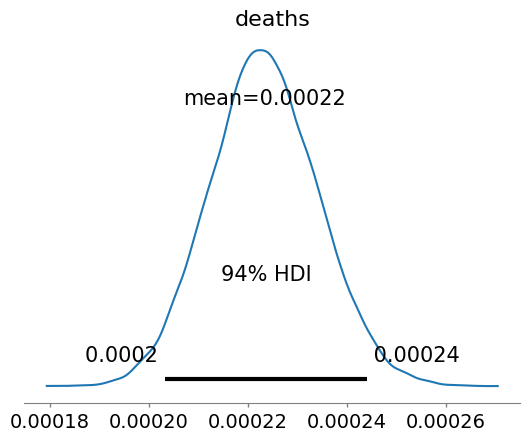

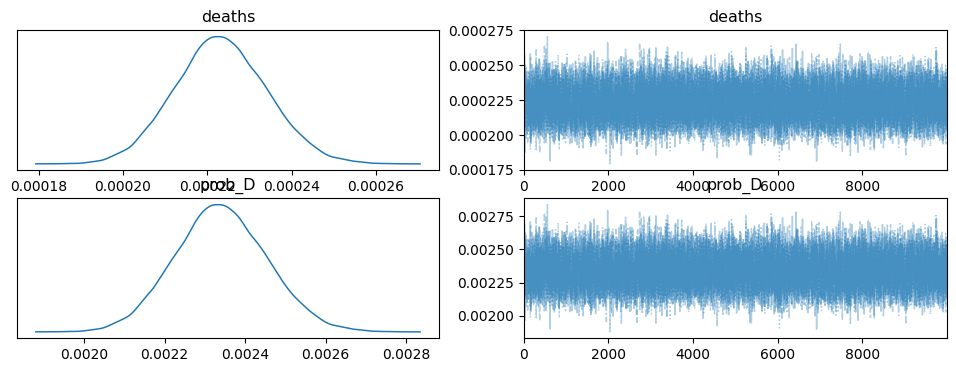

In [54]:
# Bayesian model using PyMC
with pm.Model() as model:
    people = idx_people
    prob_fire = compute_prob_fire(idx_volume, idx_risk)
    prob_D = pm.Beta("prob_D", alpha=413.5, beta=176171.5)
    deaths = pm.Deterministic("deaths", compute_death_number(people, prob_fire, prob_D))
    
    trace = pm.sample(10000)  # runs MCMC automatically

pm.plot_posterior(trace, var_names=["deaths"])
az.plot_trace(trace, combined=True)
az.summary(trace, var_names=["deaths", "prob_D"])

### Trial with uncertainty on the inputs with one building

<!-- ar_level here is not a normal integer or integer NumPy array — it’s a PyMC random variable (pm.Categorical(...)), representing a symbolic random variable in the probabilistic model graph. -->

In [55]:
# The transition matrix for risk levels, put uncertainties in the risk level
M = np.array([
    [0.985, 0.01, 0.005],  # if risk=0: 85% stay, 10% ->1, 5% ->2
    [0.01, 0.980, 0.01],  # if risk=1: 10%->0, 80% stay 1, 10%->2
    [0.005, 0.010, 0.985],  # if risk=2: 5%->0, 10% ->1, 85% stay 2
])

INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:CompoundStep
INFO:pymc.sampling.mcmc:>NUTS: [people, a_D, b_D, prob_D, volume]
INFO:pymc.sampling.mcmc:>CategoricalGibbsMetropolis: [risk]


Output()

INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 3 seconds.


Elapsed time: 3.964239 seconds


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_D,413.498,0.500,412.554,414.432,0.002,0.002,60123.0,33468.0,1.0
b_D,176171.422,50.146,176075.784,176265.123,0.208,0.245,58015.0,33321.0,1.0
deaths,0.000,0.000,0.000,0.000,0.000,0.000,50900.0,31530.0,1.0
people,44.006,2.882,39.617,48.992,0.012,0.009,53077.0,31222.0,1.0
prob_D,0.002,0.000,0.002,0.003,0.000,0.000,48712.0,32579.0,1.0
risk,1.000,0.139,1.000,1.000,0.000,0.004,118572.0,26662.0,1.0
volume,1865.157,50.228,1771.205,1960.349,0.208,0.239,58395.0,32575.0,1.0


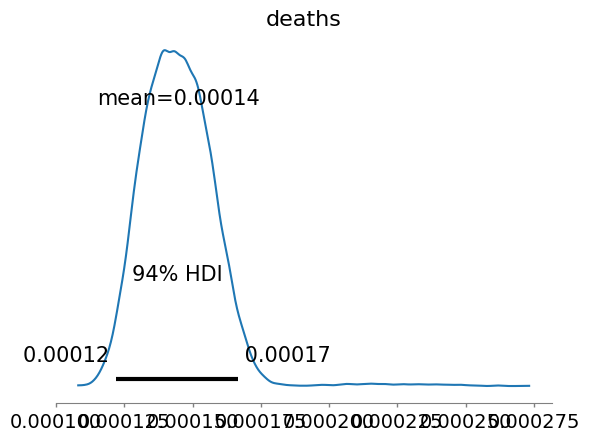

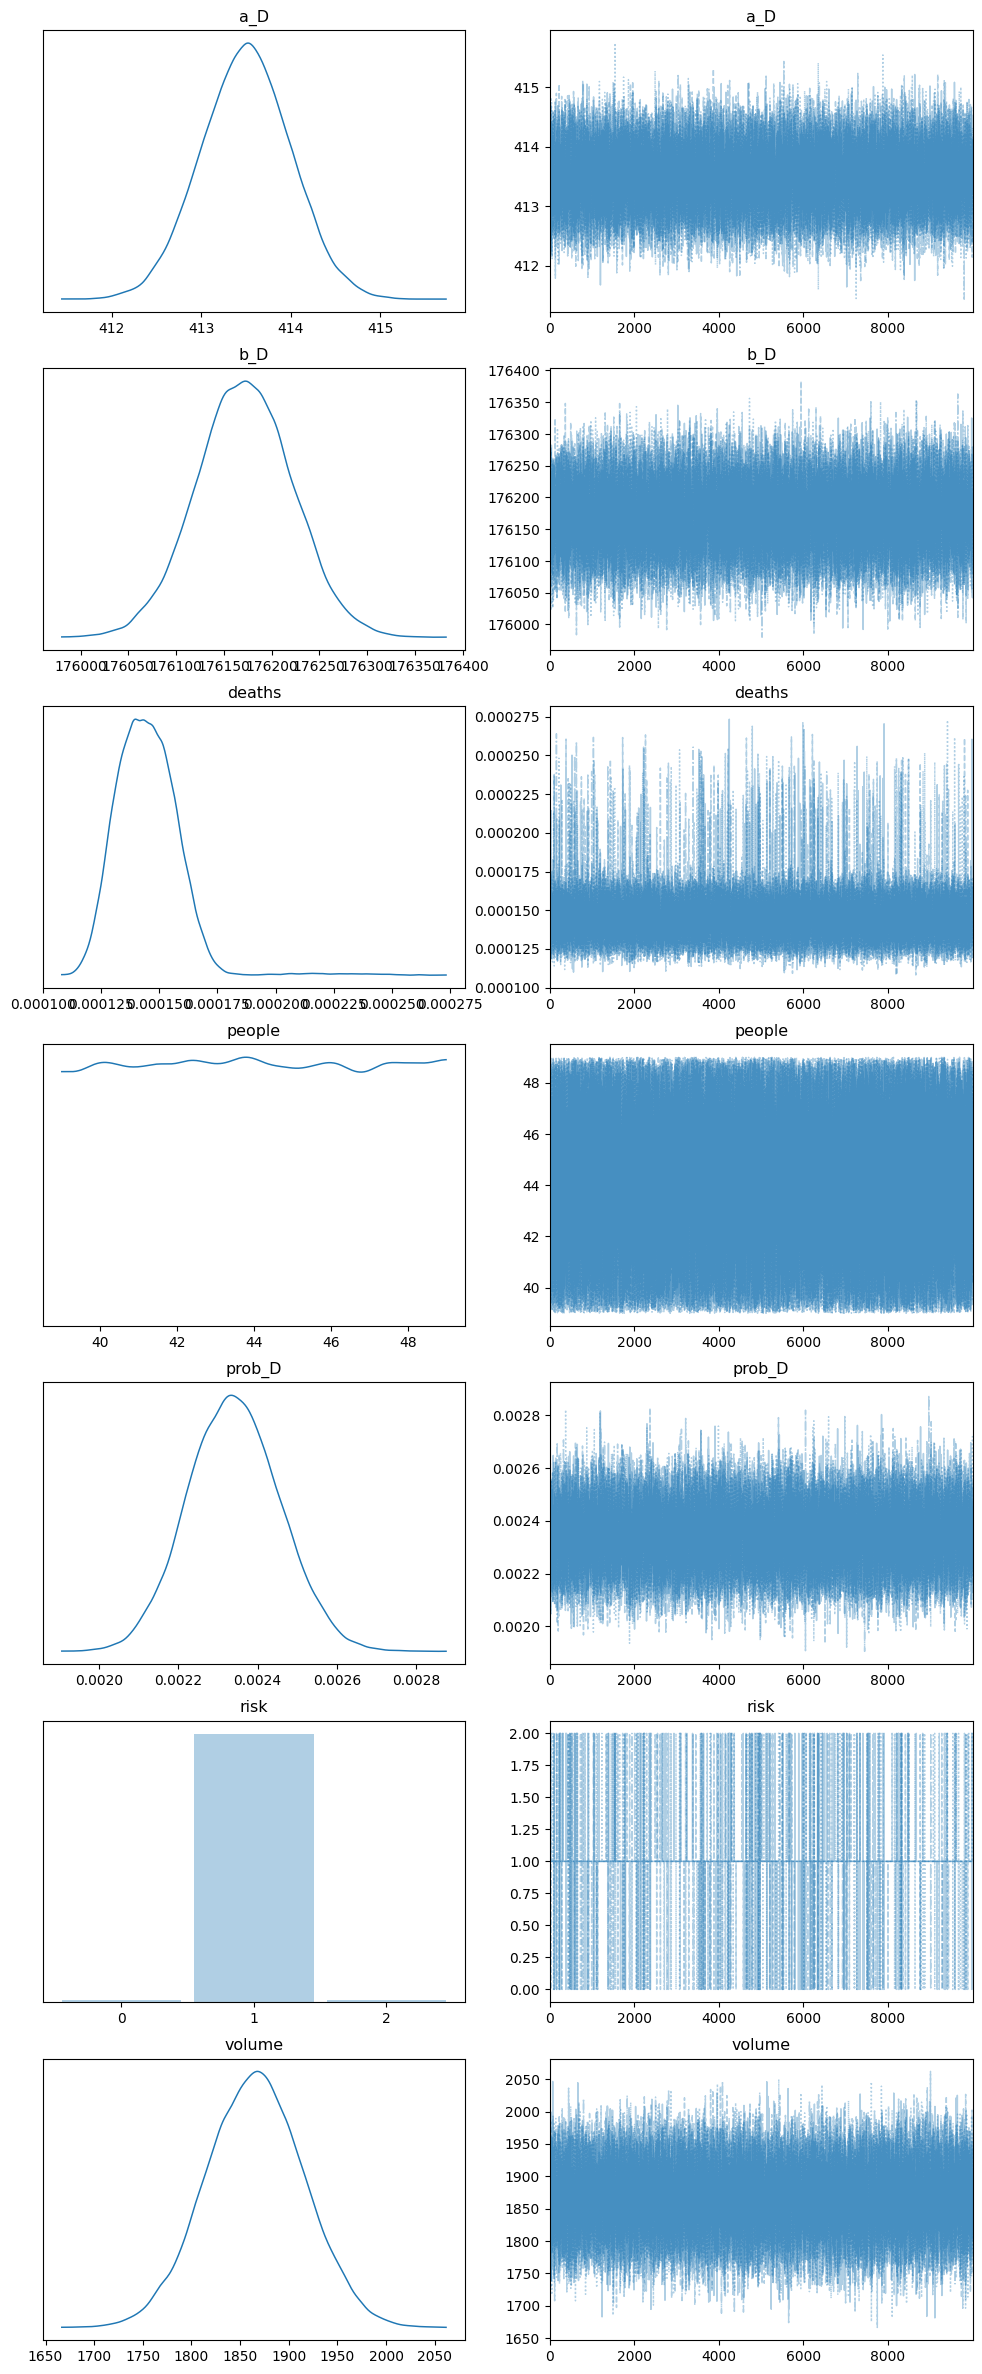

In [ ]:
start = time.perf_counter()

with pm.Model() as model:
    # Add uncertainties to the key inputs
    # For number of people, a uniform distribution around the observed value
    people = pm.Uniform("people", lower=max(0, idx_people - 5), upper=idx_people + 5)
    
    # For the probability of death, add uncertainties to the Beta distribution parameters (to show uncertainties on the model)
    a_D = pm.Normal("a_D", mu=413.5, sigma=0.5) 
    b_D = pm.Normal("b_D", mu=176171.5, sigma=50)
    prob_D = pm.Beta("prob_D", alpha=a_D, beta=b_D)
    
    # For Building volume, add a normal distribution around the observed value
    volume = pm.math.maximum(
        pm.Normal("volume", mu=idx_volume, sigma=50),
        200.0
    )

    # For activation risk, use transition matrix row corresponding to uncertainty in activation risk
    p_true = M[idx_risk]
    risk = pm.Categorical("risk", p=p_true)  # sample true risk
    
    # Get risk factors directly using switch
    alpha = pm.math.switch(
        risk,
        risk_factors["Low Risk"]["alpha"],  # risk = 0
        pm.math.switch(
            risk - 1,
            risk_factors["Middle Risk"]["alpha"],  # risk = 1
            risk_factors["High Risk"]["alpha"]     # risk = 2
        )
    )
    
    beta = pm.math.switch(
        risk,
        risk_factors["Low Risk"]["beta"],
        pm.math.switch(
            risk - 1,
            risk_factors["Middle Risk"]["beta"],
            risk_factors["High Risk"]["beta"]
        )
    )
    
    gamma = pm.math.switch(
        risk,
        risk_factors["Low Risk"]["gamma"],
        pm.math.switch(
            risk - 1,
            risk_factors["Middle Risk"]["gamma"],
            risk_factors["High Risk"]["gamma"]
        )
    )
    
    # Calculate fire probability using the selected risk factors
    prob_fire = 2/np.pi * pm.math.arctan(
        1.0 * pm.math.exp(alpha) * 
        volume ** beta / 
        pm.math.exp(21 * gamma)
    )

    deaths = pm.Deterministic("deaths", people*prob_fire*prob_D)
    
    trace = pm.sample(10000)  # runs MCMC automatically

end = time.perf_counter()
print(f"Elapsed time: {end - start:.6f} seconds")

pm.plot_posterior(trace, var_names=["deaths"])
az.plot_trace(trace, combined=True, figsize=(12, 30))
az.summary(trace)

### Sensitivity analysis

#### Based on coorelation analysis

In [8]:
# Coorelation analysis
volume = trace.posterior["volume"].values.flatten()
risk_samples = trace.posterior["risk"].values.flatten()
people_samples = trace.posterior["people"].values.flatten()
prob_D_samples = trace.posterior["prob_D"].values.flatten()

deaths_samples = trace.posterior["deaths"].values.flatten()

corr_v, _ = spearmanr(deaths_samples, volume)
print("Sensitivity (deaths vs volume):", corr_v)
corr_r, _ = spearmanr(deaths_samples, risk_samples)
print("Sensitivity (deaths vs risk):", corr_r)
corr_p, _ = spearmanr(deaths_samples, people_samples)
print("Sensitivity (deaths vs people):", corr_p)
corr_D, _ = spearmanr(deaths_samples, prob_D_samples)
print("Sensitivity (deaths vs prob_D):", corr_D)


Sensitivity (deaths vs volume): 0.12245873771907982
Sensitivity (deaths vs risk): -0.209301023395252
Sensitivity (deaths vs people): 0.8304080171682773
Sensitivity (deaths vs prob_D): 0.4610771518521061


#### Based on Mutual information analysis


Mutual Information Analysis:
MI(deaths, volume): 0.032348
MI(deaths, risk): 0.075649
MI(deaths, people): 0.628069
MI(deaths, prob_D): 0.251203
MI(deaths, a_D): 0.024944
MI(deaths, b_D): 0.022807


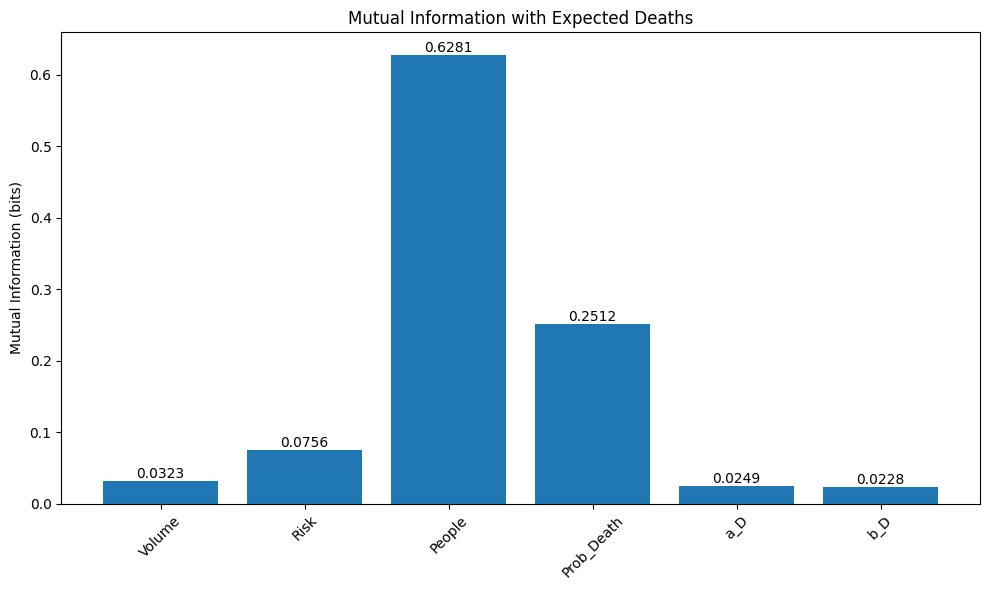

In [37]:
#-- Mutual Information Analysis ----

# Get samples from trace
volume = trace.posterior["volume"].values.flatten()
risk_samples = trace.posterior["risk"].values.flatten()
people_samples = trace.posterior["people"].values.flatten()
prob_D_samples = trace.posterior["prob_D"].values.flatten()
deaths_samples = trace.posterior["deaths"].values.flatten()
a_D_sampels = trace.posterior["a_D"].values.flatten()
b_D_sampels = trace.posterior["b_D"].values.flatten()

# Function to calculate MI for continuous variables
def calc_mi_continuous(x, y, bins=50):
    # Discretize continuous variables using bins
    x_bins = np.histogram_bin_edges(x, bins=bins)
    y_bins = np.histogram_bin_edges(y, bins=bins)
    
    x_discrete = np.digitize(x, x_bins)
    y_discrete = np.digitize(y, y_bins)
    
    return mutual_info_score(x_discrete, y_discrete)

# Calculate MI for each input variable
mi_volume = calc_mi_continuous(volume, deaths_samples)
mi_risk = mutual_info_score(risk_samples, np.digitize(deaths_samples, 
                          np.histogram_bin_edges(deaths_samples, bins=50)))
mi_people = calc_mi_continuous(people_samples, deaths_samples)
mi_prob_D = calc_mi_continuous(prob_D_samples, deaths_samples)
mi_a_D = calc_mi_continuous(a_D_sampels, deaths_samples)
mi_b_D = calc_mi_continuous(b_D_sampels, deaths_samples)

# Print results
print("\nMutual Information Analysis:")
print(f"MI(deaths, volume): {mi_volume:.6f}")
print(f"MI(deaths, risk): {mi_risk:.6f}")
print(f"MI(deaths, people): {mi_people:.6f}")
print(f"MI(deaths, prob_D): {mi_prob_D:.6f}")
print(f"MI(deaths, a_D): {mi_a_D:.6f}")
print(f"MI(deaths, b_D): {mi_b_D:.6f}")

# Plot MI values
plt.figure(figsize=(10, 6))
variables = ['Volume', 'Risk', 'People', 'Prob_Death', 'a_D', 'b_D']
mi_values = [mi_volume, mi_risk, mi_people, mi_prob_D, mi_a_D, mi_b_D]

bars = plt.bar(variables, mi_values)
plt.title('Mutual Information with Expected Deaths')
plt.ylabel('Mutual Information (bits)')
plt.xticks(rotation=45)
# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### sobol_indices

In [ ]:
import numpy as np
from scipy.stats import sobol_indices, uniform, norm, beta, rv_discrete
import matplotlib.pyplot as plt

# Example data
idx_people = 100
idx_volume = 5000

# Placeholder functions (replace with your actual implementations)
def compute_prob_fire(volume, ar_level):
    """Placeholder - replace with your actual function"""
    return 0.01 + 0.05 * ar_level + volume * 0.000001

def compute_death_number(people, prob_fire, prob_D):
    """Placeholder - replace with your actual function"""
    return people * prob_fire * prob_D

print("=" * 70)
print("Sobol Analysis with Discrete ar_level and Beta-distributed prob_D")
print("=" * 70)

# ------------------------------
# APPROACH 1: Sample ar_level from discrete distribution
# The problem is the how to put proper uncertainty in the ar_level
# ------------------------------
print("\nAPPROACH 1: Using discrete ar_level distribution")
print("-" * 70)

class DiscreteARLevel:
    """Custom distribution for ar_level with specific probabilities."""
    def __init__(self):
        self.values = np.array([0, 1, 2])
        self.probs = np.array([0.985, 0.01, 0.005])
        self.cumprobs = np.cumsum(self.probs)
    
    def rvs(self, size=1, random_state=None):
        """Sample from discrete distribution"""
        if random_state is None:
            u = np.random.uniform(0, 1, size)
        else:
            rng = np.random.default_rng(random_state)
            u = rng.uniform(0, 1, size)
        return self.ppf(u)
    
    def ppf(self, q):
        """Inverse CDF (required for Sobol sampling)"""
        # Map [0,1] quantiles to discrete values based on cumulative probs
        q = np.atleast_1d(q)
        result = np.zeros_like(q, dtype=float)  # Keep as float for sobol sampling
        
        # q < 0.985 -> 0
        # 0.985 <= q < 0.995 -> 1
        # q >= 0.995 -> 2
        result[q < self.cumprobs[0]] = 0.0
        result[(q >= self.cumprobs[0]) & (q < self.cumprobs[1])] = 1.0
        result[q >= self.cumprobs[1]] = 2.0
        
        return result if result.shape else result.item()

# Create custom distributions
ar_level_dist = DiscreteARLevel()

def complex_model_with_discrete(x):
    """Model with discrete ar_level and Beta-sampled prob_D."""
    people = x[:, 0]
    a_D = x[:, 1]
    b_D = x[:, 2]
    volume = np.maximum(x[:, 3], 200.0)
    ar_level = x[:, 4].astype(int)  # Ensure integer array: 0, 1, or 2
    
    # Sample prob_D from Beta(a_D, b_D) for each sample
    # Each sample has its own a_D[i], b_D[i], so we need individual Beta samples
    n_samples = len(people)
    prob_D = np.zeros(n_samples)
    
    for i in range(n_samples):
        # Ensure parameters are valid (positive)
        a_safe = max(a_D[i], 0.1)
        b_safe = max(b_D[i], 0.1)
        prob_D[i] = beta.rvs(a_safe, b_safe, size=1)
    
    # Vectorized computation - handle arrays
    prob_fire = np.zeros(n_samples)
    deaths = np.zeros(n_samples)
    
    for i in range(n_samples):
        prob_fire[i] = compute_prob_fire(volume[i], ar_level[i])
        deaths[i] = compute_death_number(people[i], prob_fire[i], prob_D[i])
    
    return deaths

# Define distributions
dists_approach1 = [
    uniform(loc=max(0, idx_people-5), scale=10),  # people: Uniform
    norm(loc=413.5, scale=0.5),                    # a_D: Normal
    norm(loc=176171.5, scale=50),                  # b_D: Normal  
    norm(loc=idx_volume, scale=50),                # volume: Normal
    ar_level_dist,                                 # ar_level: Custom discrete
]

print("\nParameter distributions:")
print(f"  people:   Uniform({max(0, idx_people-5)}, {idx_people+5})")
print(f"  a_D:      Normal(413.5, 0.5)")
print(f"  b_D:      Normal(176171.5, 50)")
print(f"  volume:   Normal({idx_volume}, 50)")
print(f"  ar_level: Discrete with P(0)=0.985, P(1)=0.01, P(2)=0.005")
print(f"  prob_D:   Beta(a_D, b_D) - sampled inside model")

print("\nRunning Sobol analysis (this may take a moment)...")
indices1 = sobol_indices(func=complex_model_with_discrete, n=256, dists=dists_approach1)

params = ['people', 'a_D', 'b_D', 'volume', 'ar_level']
print("\nFirst-order indices (direct effects):")
for param, idx in zip(params, indices1.first_order):
    print(f"   {param:12s}: {idx:.6f}")

print("\nTotal-order indices (direct + interaction effects):")
for param, idx in zip(params, indices1.total_order):
    print(f"   {param:12s}: {idx:.6f}")

# ------------------------------
# APPROACH 2: Simplified - treat ar_level as continuous for faster computation
# ------------------------------
print("\n" + "=" * 70)
print("APPROACH 2: Simplified (ar_level as continuous, prob_D as mean)")
print("-" * 70)
print("Faster approximation - good for initial exploration")

def complex_model_simplified(x):
    """Simplified model with continuous ar_level and mean prob_D."""
    people = x[:, 0]
    a_D = x[:, 1]
    b_D = x[:, 2]
    volume = np.maximum(x[:, 3], 200.0)
    ar_level_continuous = x[:, 4]  # Treat as continuous 0-2
    
    # Round to nearest discrete level for model evaluation
    ar_level = np.round(np.clip(ar_level_continuous, 0, 2)).astype(int)
    
    # Use mean of Beta distribution (faster)
    prob_D = a_D / (a_D + b_D)
    
    prob_fire = compute_prob_fire(volume, ar_level)
    deaths = compute_death_number(people, prob_fire, prob_D)
    
    return deaths

dists_approach2 = [
    uniform(loc=max(0, idx_people-5), scale=10),
    norm(loc=413.5, scale=0.5),
    norm(loc=176171.5, scale=50),
    norm(loc=idx_volume, scale=50),
    uniform(loc=0, scale=2),  # ar_level: continuous 0-2, will be rounded
]

print("\nRunning simplified Sobol analysis...")
indices2 = sobol_indices(func=complex_model_simplified, n=512, dists=dists_approach2)

print("\nFirst-order indices:")
for param, idx in zip(params, indices2.first_order):
    print(f"   {param:12s}: {idx:.6f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: First-order comparison
ax = axes[0, 0]
x_pos = np.arange(len(params))
width = 0.35
ax.barh(x_pos - width/2, indices1.first_order, width, alpha=0.7, 
        label='Approach 1 (Exact)', color='steelblue')
ax.barh(x_pos + width/2, indices2.first_order, width, alpha=0.7, 
        label='Approach 2 (Simplified)', color='coral')
ax.set_yticks(x_pos)
ax.set_yticklabels(params)
ax.set_xlabel('Sensitivity Index')
ax.set_title('First-Order Sobol Indices Comparison')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# Plot 2: Total-order comparison
ax = axes[0, 1]
ax.barh(x_pos - width/2, indices1.total_order, width, alpha=0.7, 
        label='Approach 1 (Exact)', color='steelblue')
ax.barh(x_pos + width/2, indices2.total_order, width, alpha=0.7, 
        label='Approach 2 (Simplified)', color='coral')
ax.set_yticks(x_pos)
ax.set_yticklabels(params)
ax.set_xlabel('Sensitivity Index')
ax.set_title('Total-Order Sobol Indices Comparison')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# Plot 3: First vs Total (Approach 1)
ax = axes[1, 0]
ax.barh(x_pos, indices1.first_order, alpha=0.7, label='First-order', color='steelblue')
ax.barh(x_pos, indices1.total_order, alpha=0.4, label='Total-order', color='lightblue')
ax.set_yticks(x_pos)
ax.set_yticklabels(params)
ax.set_xlabel('Sensitivity Index')
ax.set_title('Approach 1: First vs Total Order')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# Plot 4: Interaction effects (Total - First)
ax = axes[1, 1]
interaction1 = indices1.total_order - indices1.first_order
interaction2 = indices2.total_order - indices2.first_order
ax.barh(x_pos - width/2, interaction1, width, alpha=0.7, 
        label='Approach 1', color='green')
ax.barh(x_pos + width/2, interaction2, width, alpha=0.7, 
        label='Approach 2', color='orange')
ax.set_yticks(x_pos)
ax.set_yticklabels(params)
ax.set_xlabel('Interaction Effect (ST - S1)')
ax.set_title('Interaction Effects')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("INTERPRETATION:")
print("=" * 70)
print("- First-order index: Direct effect of varying each parameter alone")
print("- Total-order index: Direct + all interactions with other parameters")
print("- Interaction (ST - S1): How much parameter interacts with others")
print("")
print("Large first-order → parameter matters independently")
print("Large interaction → parameter's effect depends on other parameters")
print("Small total-order → parameter doesn't matter much")
print("=" * 70)

print("\n" + "=" * 70)
print("RECOMMENDATIONS:")
print("=" * 70)
print("1. Use APPROACH 1 for accurate results")
print("   - Properly samples ar_level from discrete distribution")
print("   - Samples prob_D from Beta(a_D, b_D)")
print("   - Slower but correct")
print("")
print("2. Use APPROACH 2 for quick exploration")
print("   - Treats ar_level as continuous (rounded)")
print("   - Uses mean of Beta (approximation)")
print("   - Much faster, good for debugging")
print("")
print("3. If ar_level is strongly concentrated at 0 (98.5%):")
print("   - Consider fixing it at 0 and analyzing conditional sensitivity")
print("   - Or run separate analyses for ar_level=0,1,2")
print("")
print("4. The Beta sampling adds computational cost")
print("   - If a_D, b_D have low variance, using mean is reasonable")
print("   - Check if Beta(413.5, 176171.5) has tight distribution")
print("=" * 70)

Sobol Analysis with Discrete ar_level and Beta-distributed prob_D

APPROACH 1: Using discrete ar_level distribution
----------------------------------------------------------------------

Parameter distributions:
  people:   Uniform(95, 105)
  a_D:      Normal(413.5, 0.5)
  b_D:      Normal(176171.5, 50)
  volume:   Normal(5000, 50)
  ar_level: Discrete with P(0)=0.985, P(1)=0.01, P(2)=0.005
  prob_D:   Beta(a_D, b_D) - sampled inside model

Running Sobol analysis (this may take a moment)...


/var/folders/1h/j0fmlycx6xd8wvffwc89hj3m0000gn/T/ipykernel_7840/2566646809.py:79: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob_D[i] = beta.rvs(a_safe, b_safe, size=1)


ValueError: 'func' output should have a shape ``(s, -1)`` with ``s`` the number of output.

### Uncertainty Analysis

#### Credible interval analysis 95%

In [11]:
# Just be the credible interval analysis 2.5%-97.5%
ci_deaths = az.hdi(trace, var_names=["deaths"], hdi_prob=0.95)
print(f"95% Credible Interval for Expected Deaths: {ci_deaths['deaths'].values[0]*100}% ~ {ci_deaths['deaths'].values[1]*100}%")

95% Credible Interval for Expected Deaths: 0.015873621821729366% ~ 0.022989063783853843%


Entropy: Entropy provides a useful metric for comparing uncertainty across different models or datasets, and it is commonly used in information theory and decision theory.


Entropy Analysis:
Entropy of death distribution: 3.1768 bits


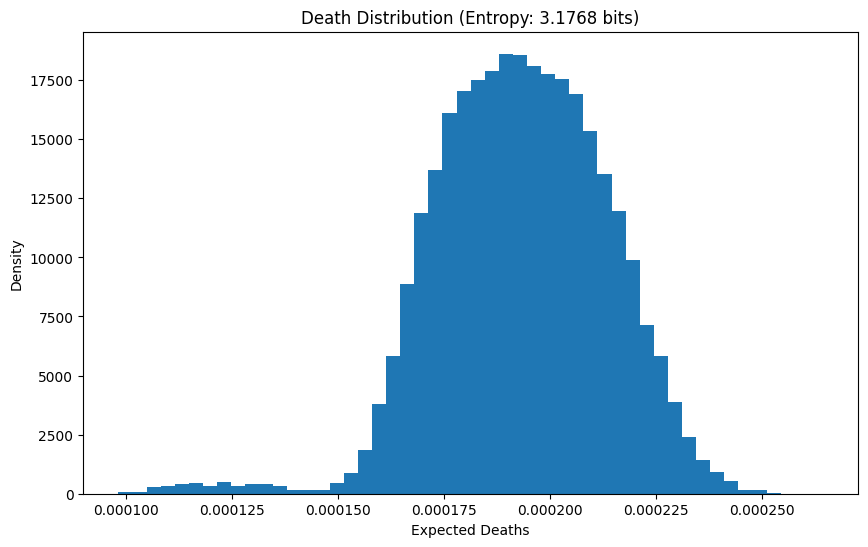

In [13]:
def calculate_entropy(samples, bins=50):
    hist, _ = np.histogram(samples, bins=bins, density=True)
    hist = hist[hist > 0]  # Remove zero entries to avoid log(0)
    hist = hist / np.sum(hist)  # Normalize histogram
    entropy = -np.sum(hist * np.log(hist))
    return entropy

deaths_samples = trace.posterior["deaths"].values.flatten()
deaths_entropy = calculate_entropy(deaths_samples, bins=50)
print(f"\nEntropy Analysis:")
print(f"Entropy of death distribution: {deaths_entropy:.4f} bits")

# Visualize distribution with entropy
plt.figure(figsize=(10, 6))
plt.hist(deaths_samples, bins=50, density=True)
plt.title(f'Death Distribution (Entropy: {deaths_entropy:.4f} bits)')
plt.xlabel('Expected Deaths')
plt.ylabel('Density')
plt.show()

#### Fix aleatory uncertainty 
step1: run this block\
step2: do sensitivity analysis above

INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:CompoundStep
INFO:pymc.sampling.mcmc:>NUTS: [people, a_D, b_D, prob_D, volume]
INFO:pymc.sampling.mcmc:>CategoricalGibbsMetropolis: [risk]


Output()

INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 3 seconds.


Elapsed time: 4.583532 seconds


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
E_prob_D,0.002,0.000,0.002,0.002,0.000,0.000,51457.0,33178.0,1.0
a_D,413.503,0.498,412.564,414.432,0.002,0.002,50561.0,32548.0,1.0
b_D,176171.575,50.055,176078.099,176265.744,0.198,0.243,63759.0,32987.0,1.0
deaths,0.000,0.000,0.000,0.000,0.000,0.000,50862.0,32381.0,1.0
people,42.013,1.728,39.142,44.779,0.007,0.006,46384.0,28639.0,1.0
prob_D,0.002,0.000,0.002,0.003,0.000,0.000,56273.0,33745.0,1.0
risk,1.980,0.172,2.000,2.000,0.001,0.006,14756.0,40000.0,1.0
volume,1982.707,49.953,1889.597,2077.656,0.196,0.250,65194.0,33397.0,1.0


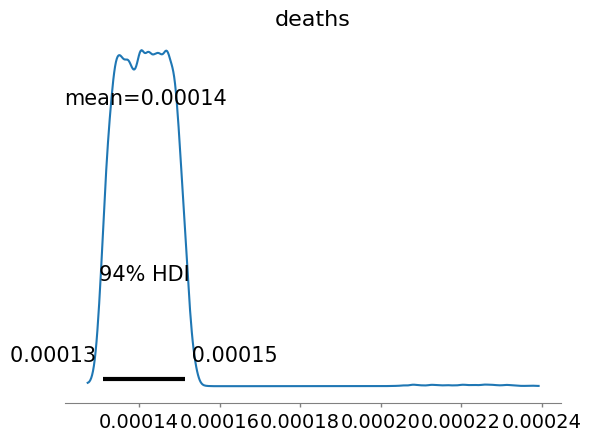

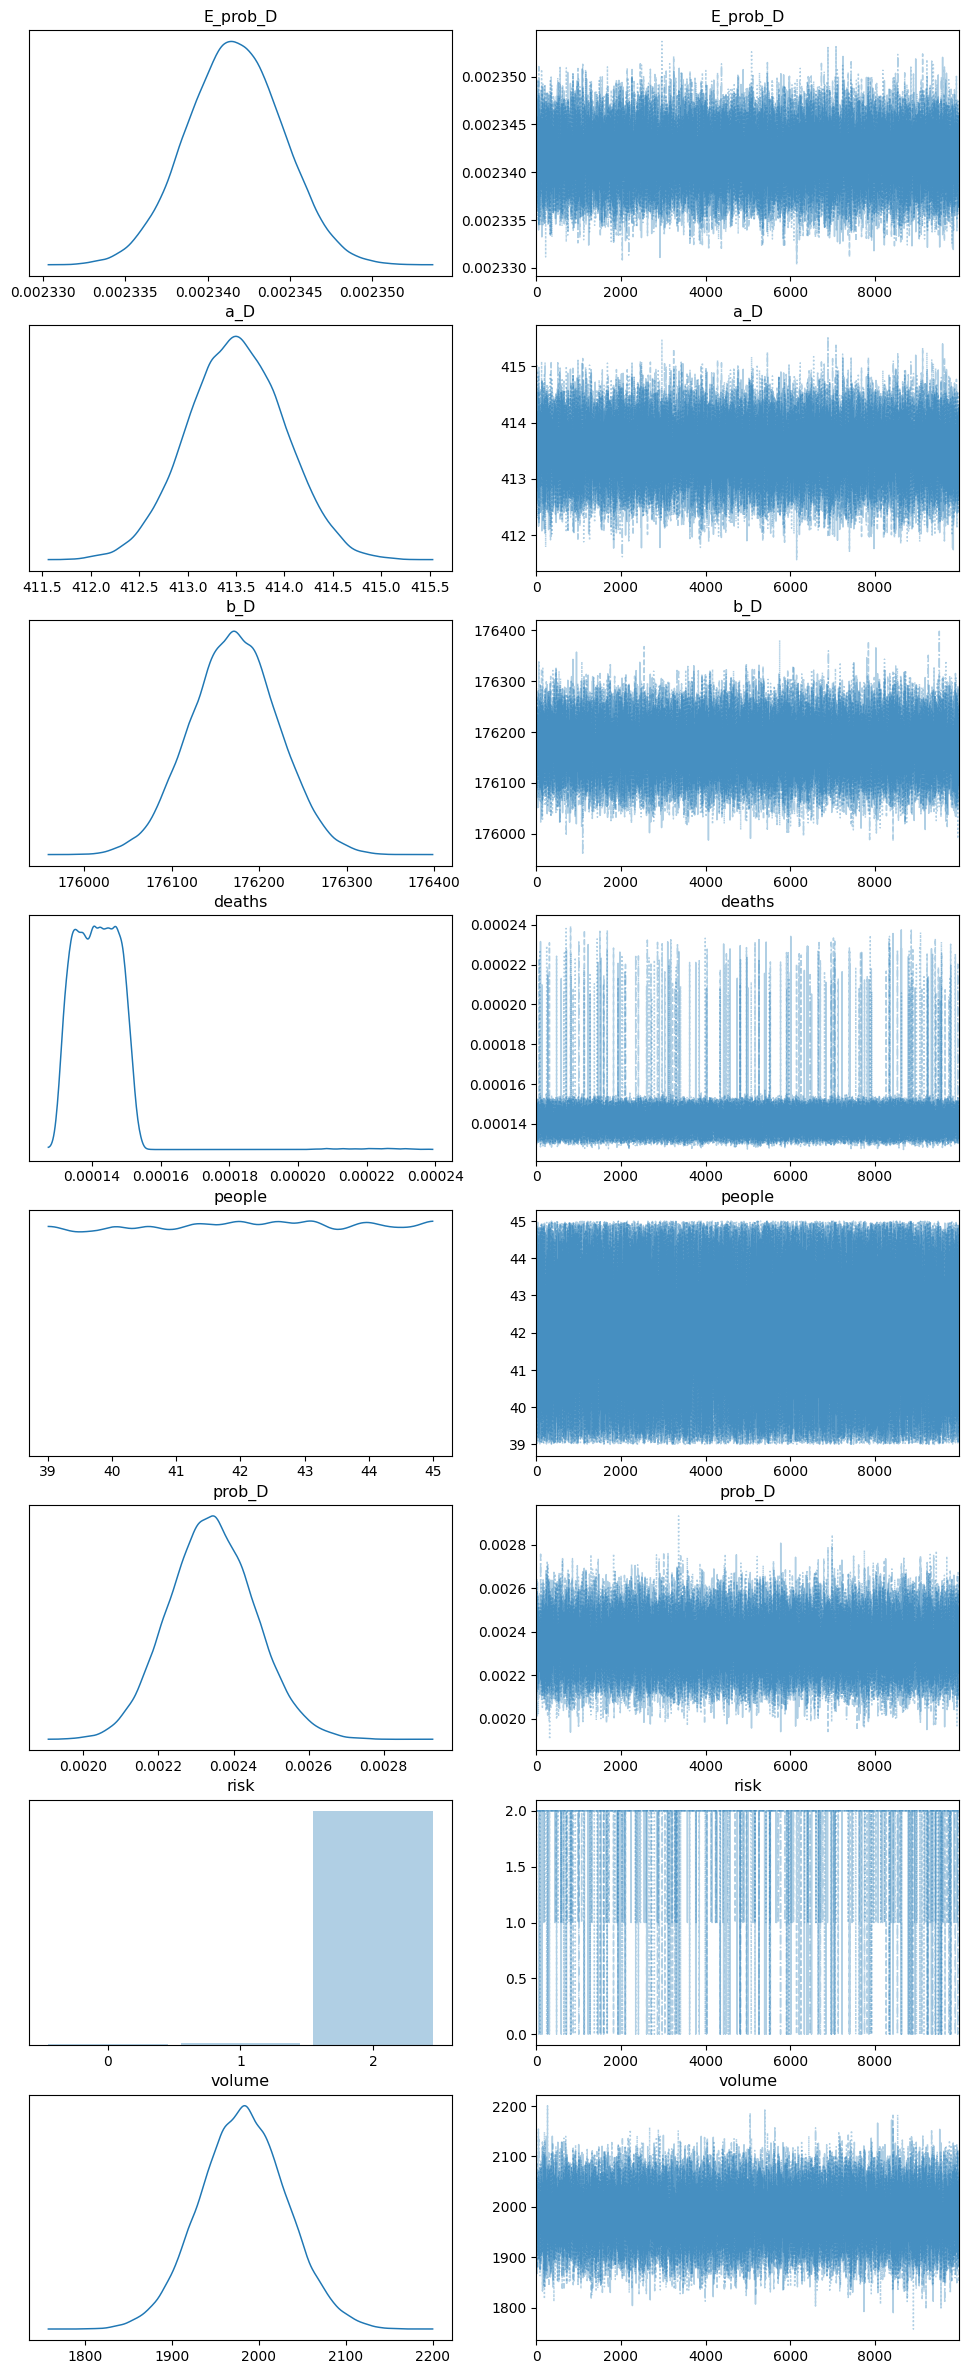

In [ ]:
#------------------------------
# Bayesian model using PyMC with Epistemic Uncertainties 
# Consider the probability of death as aleatory uncertainty
#------------------------------
# People and the probability of death are important factores affecting the uncertainty in expected deaths

# If view the probability of death as aleatory uncertainty
# The number of people will be the main driver of the epistemic uncertainty in the expected deaths

# If view the probability of death and the numebr of people as aleatory uncertainties
# The volume will be the main driver of the epistemic uncertainty in the expected deaths

start = time.perf_counter()

with pm.Model() as model:
    # Add uncertainties to the key inputs
    # For number of people, a uniform distribution around the observed value
    people = pm.Uniform("people", lower=max(0, idx_people - 3), upper=idx_people + 3)

    # For the probability of death, add uncertainties to the Beta distribution parameters (to show uncertainties on the model)
    a_D = pm.Normal("a_D", mu=413.5, sigma=0.5) 
    b_D = pm.Normal("b_D", mu=176171.5, sigma=50)
    prob_D = pm.Beta("prob_D", alpha=a_D, beta=b_D)
    E_prob_D = pm.Deterministic("E_prob_D", a_D / (a_D + b_D))
    
    # For Building volume, add a normal distribution around the observed value
    volume = pm.math.maximum(
        pm.Normal("volume", mu=idx_volume, sigma=50),
        200.0
    )

    # For activation risk, use transition matrix row corresponding to uncertainty in activation risk
    p_true = M[idx_risk]
    risk = pm.Categorical("risk", p=p_true)  # sample true risk
    
    # Get risk factors directly using switch
    alpha = pm.math.switch(
        risk,
        risk_factors["Low Risk"]["alpha"],  # risk = 0
        pm.math.switch(
            risk - 1,
            risk_factors["Middle Risk"]["alpha"],  # risk = 1
            risk_factors["High Risk"]["alpha"]     # risk = 2
        )
    )
    
    beta = pm.math.switch(
        risk,
        risk_factors["Low Risk"]["beta"],
        pm.math.switch(
            risk - 1,
            risk_factors["Middle Risk"]["beta"],
            risk_factors["High Risk"]["beta"]
        )
    )
    
    gamma = pm.math.switch(
        risk,
        risk_factors["Low Risk"]["gamma"],
        pm.math.switch(
            risk - 1,
            risk_factors["Middle Risk"]["gamma"],
            risk_factors["High Risk"]["gamma"]
        )
    )
    
    # Calculate fire probability using the selected risk factors
    prob_fire = 2/np.pi * pm.math.arctan(
        1.0 * pm.math.exp(alpha) * 
        volume ** beta / 
        pm.math.exp(21 * gamma)
    )

    deaths = pm.Deterministic("deaths", people*prob_fire*E_prob_D)
    
    trace = pm.sample(10000)  # runs MCMC automatically

end = time.perf_counter()
print(f"Elapsed time: {end - start:.6f} seconds")

pm.plot_posterior(trace, var_names=["deaths"])
az.plot_trace(trace, combined=True, figsize=(12, 30))
az.summary(trace)

## For Multiple buildings

At this stage, analysis is for each building. For multiple buildings, just conduct the analysis for each one. Focus on mapping.

## PGMPY

In [ ]:
import pandas as pd
import numpy as np

# Example: discretize into 3 bins
df['X_discrete'] = pd.cut(df['X'], bins=3, labels=[0,1,2])
df['X_discrete'] = pd.qcut(df['X'], q=3, labels=[0,1,2])
bins = [-np.inf, 0.5, 1.5, np.inf]
labels = [0,1,2]
df['X_discrete'] = pd.cut(df['X'], bins=bins, labels=labels)
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator

# Step 1: discretize continuous columns
df['X_discrete'] = pd.qcut(df['X'], q=3, labels=[0,1,2])
df['Y_discrete'] = pd.qcut(df['Y'], q=3, labels=[0,1,2])

# Step 2: define network structure
model = BayesianNetwork([('X_discrete', 'Y_discrete')])

# Step 3: estimate CPDs
model.fit(df, estimator=MaximumLikelihoodEstimator)

# Step 4: inference
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)
print(infer.query(variables=['Y_discrete'], evidence={'X_discrete':1}))



## Some math calculations for verification

In [9]:
alpha = 413.5
beta = 176171.5
mean = alpha / (alpha + beta)
var = (alpha * beta) / ((alpha + beta)**2 * (alpha + beta + 1))
print(f"Mean Probability of Death: {mean:.8f}, Variance: {var:.10f}")

Mean Probability of Death: 0.00234165, Variance: 0.0000000132


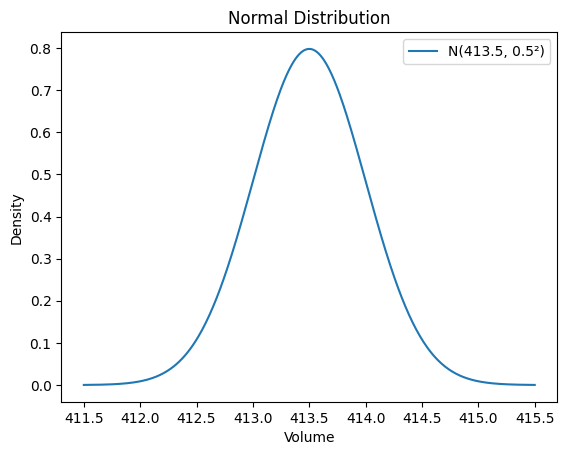

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
mu = 413.5     # mean
sigma = 0.5   # standard deviation

# Generate x-values
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 500)

# Compute PDF
pdf = norm.pdf(x, mu, sigma)

# Plot
plt.plot(x, pdf, label=f"N({mu}, {sigma}²)")
plt.title("Normal Distribution")
plt.xlabel("Volume")
plt.ylabel("Density")
plt.legend()
plt.show()



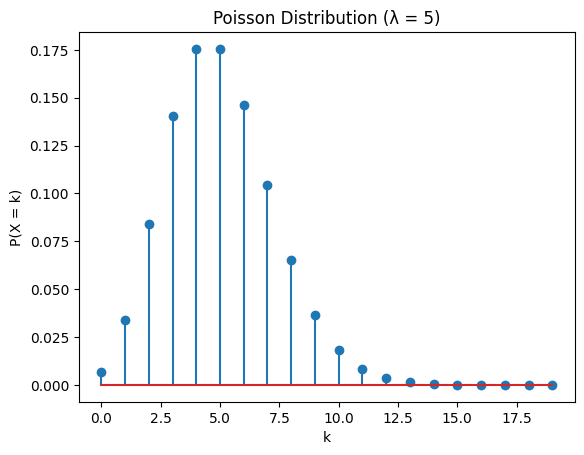

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Parameters
lam = 5  # λ = expected rate

# Support (integer values)
x = np.arange(0, 20)

# PMF (probability mass function)
pmf = poisson.pmf(x, lam)

# Plot
plt.stem(x, pmf)
plt.title(f"Poisson Distribution (λ = {lam})")
plt.xlabel("k")
plt.ylabel("P(X = k)")
plt.show()



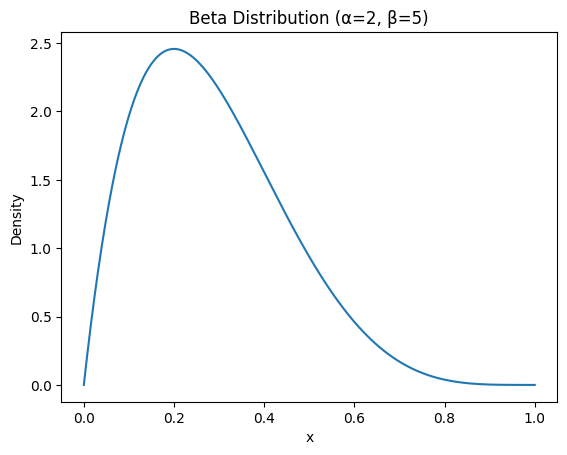

In [53]:
from scipy.stats import beta

a, b = 2, 5
x = np.linspace(0, 1, 500)
pdf = beta.pdf(x, a, b)

plt.plot(x, pdf)
plt.title(f"Beta Distribution (α={a}, β={b})")
plt.xlabel("x")
plt.ylabel("Density")
plt.show()
